
## Include packages



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import Model, models, optimizers, metrics
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## util functions

In [3]:
# Bicubic Downsample For Oxford Dogs
def bicubic_kernel(x, a=-0.5):
  !wget https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html
  if abs(x) <= 1:
    return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
  elif 1 < abs(x) and abs(x) < 2:
    return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
  else:
    return 0

def build_filter(factor):
  size = factor*4
  k = np.zeros((size))
  for i in range(size):
    x = (1/factor)*(i- np.floor(size/2) +0.5)
    k[i] = bicubic_kernel(x)
  k = k / np.sum(k)
  # make 2d
  k = np.outer(k, k.T)
  k = tf.constant(k, dtype=tf.float32, shape=(size, size, 1, 1))
  return tf.concat([k, k, k], axis=2)

def apply_bicubic_downsample(x, filter, factor):
  """Downsample x by a factor of factor, using the filter built by build_filter()
  x: a rank 4 tensor with format NHWC
  filter: from build_filter(factor)
  factor: downsampling factor (ex: factor=2 means the output size is (h/2, w/2))
  """
  # using padding calculations from https://www.tensorflow.org/api_guides/python/nn#Convolution
  filter_height = factor*4
  filter_width = factor*4
  strides = factor
  pad_along_height = max(filter_height - strides, 0)
  pad_along_width = max(filter_width - strides, 0)
  # compute actual padding values for each side
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  # apply mirror padding
  x = tf.pad(x, [[0,0], [pad_top,pad_bottom], [pad_left,pad_right], [0,0]], mode='REFLECT')
  # downsampling performed by strided conv
  x = tf.nn.depthwise_conv2d(x, filter=filter, strides=[1,strides,strides,1], padding='VALID')
  return x

In [4]:
# normalize
def normalize(image):
    image = tf.cast(image, dtype=tf.float32)
    return (image-tf.math.reduce_min(image))/(tf.math.reduce_max(image)-tf.math.reduce_min(image))

## Load the data and build tensorflow dataset

In [6]:
dim = tf.constant([224, 224], dtype=tf.int32)
batch_size = 32
# create the bicubic kernel. This can be reused in multiple downsample operations
k = build_filter(factor=4)
ds = tfds.load('oxford_iiit_pet')

# bulit dataset
ds_train = ds['train'].map(lambda ele: tf.image.resize_with_crop_or_pad(ele['image'], 224, 224))
ds_train = ds_train.map(lambda x: tf.divide(tf.cast(x, tf.float32), 255))
ds_train = ds_train.repeat().batch(batch_size).prefetch(16)
ds_train = ds_train.map(lambda x: (apply_bicubic_downsample(x, filter=k, factor=4), x))
ds_train = ds_train.map(lambda x, y:(normalize(x), normalize(y)))

ds_test = ds['test'].map(lambda ele: tf.image.resize_with_crop_or_pad(ele['image'], 224, 224))
ds_test = ds_test.map(lambda x: tf.divide(tf.cast(x, tf.float32), 255))
ds_test = ds_test.repeat().batch(batch_size).prefetch(16)
ds_test = ds_test.map(lambda x: (apply_bicubic_downsample(x, filter=k, factor=4), x))
ds_test = ds_test.map(lambda x, y:(normalize(x), normalize(y)))

--2021-02-12 16:31:41--  https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html
Resolving clouard.users.greyc.fr (clouard.users.greyc.fr)... 193.55.128.8, 2001:660:7101::8
Connecting to clouard.users.greyc.fr (clouard.users.greyc.fr)|193.55.128.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index-en.html’

index-en.html           [ <=>                ]  19.89K  --.-KB/s    in 0.08s   

2021-02-12 16:31:43 (239 KB/s) - ‘index-en.html’ saved [20364]

--2021-02-12 16:31:43--  https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html
Resolving clouard.users.greyc.fr (clouard.users.greyc.fr)... 193.55.128.8, 2001:660:7101::8
Connecting to clouard.users.greyc.fr (clouard.users.greyc.fr)|193.55.128.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index-en.html.1’

index-en.html.1         [ <=>                ]  19.89K  --.-KB/s 

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteWL9HJA/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteWL9HJA/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## take a look at the data

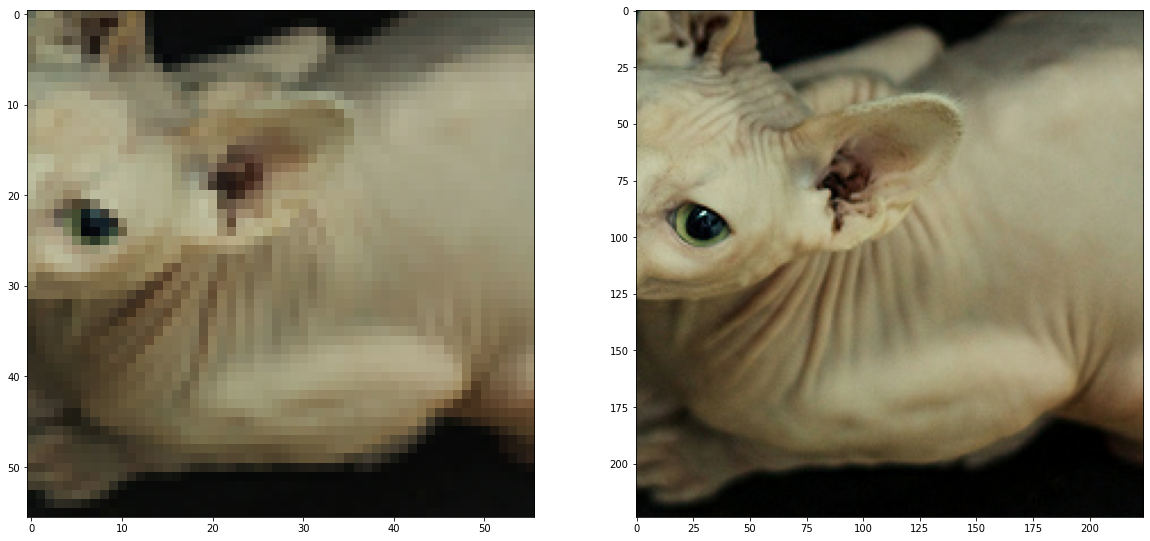

In [7]:
for lr, hr in ds_train: break

fig,ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(lr[0].numpy())
ax[1].imshow(hr[0].numpy())

plt.show()

## SISR Network

In [8]:
class MySRResNet(tf.keras.Model):
  def __init__(self):
    super(MySRResNet, self).__init__(name='')
    
    # k9n64s1
    self.conv1 = tf.keras.layers.Conv2D(64, 9, 1, padding='same')
    self.prelu1 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    
    # B residual blocks
    # conv2_1, k3n64s1
    self.conv21a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn21a = tf.keras.layers.BatchNormalization()
    self.prelu21a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv21b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn21b = tf.keras.layers.BatchNormalization()
    
    self.x21_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x21 = tf.keras.layers.BatchNormalization()

     
    # conv2_2, k3n64s1
    self.conv22a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn22a = tf.keras.layers.BatchNormalization()
    self.prelu22a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv22b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn22b = tf.keras.layers.BatchNormalization()
    
    self.x22_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x22 = tf.keras.layers.BatchNormalization()

    # conv2_3, k3n64s1
    self.conv23a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn23a = tf.keras.layers.BatchNormalization()
    self.prelu23a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv23b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn23b = tf.keras.layers.BatchNormalization()
    
    self.x23_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x23 = tf.keras.layers.BatchNormalization()


    # conv2_4, k3n64s1
    self.conv24a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn24a = tf.keras.layers.BatchNormalization()
    self.prelu24a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv24b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn24b = tf.keras.layers.BatchNormalization()
    
    self.x24_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x24 = tf.keras.layers.BatchNormalization()


    # conv2_5, k3n64s1 -- end of B residual block
    self.conv25a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn25a = tf.keras.layers.BatchNormalization()
    self.prelu25a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv25b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn25b = tf.keras.layers.BatchNormalization()
    
    self.x25_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x25 = tf.keras.layers.BatchNormalization()


    # conv3, k3n64s1
    self.conv3 = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.x3_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x3 = tf.keras.layers.BatchNormalization()

    # conv4_1, k3n256s1
    self.conv41 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu41 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    # conv4_2
    self.conv42 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu42 = tf.keras.layers.PReLU(alpha_initializer='zeros')

    # conv5, k9n3s1
    self.conv5 = tf.keras.layers.Conv2D(3, 9, 1, padding='same')
    

  def call(self, input_tensor, training=False):
    input_tensor = self.conv1(input_tensor)
    input_tensor = self.prelu1(input_tensor)
    
     # B residual blocks
    # conv2_1, k3n64s1
    x = self.conv21a(input_tensor)
    x = self.bn21a(x)
    x = self.prelu21a(x)                          
    x = self.conv21b(x)                         
    x = self.bn21b(x)                 
    x_append = self.x21_append(input_tensor)
    x += x_append                   
    x21 = self.bn_x21(x)                 

     
    # conv2_2, k3n64s1
    x = self.conv22a(x21)          
    x = self.bn22a(x)               
    x = self.prelu22a(x)                 
    x = self.conv22b(x)          
    x = self.bn22b(x)                  
    x_append = self.x22_append(x21)
    x += x_append                   
    x22 = self.bn_x22(x)                 

    # conv2_3, k3n64s1
    x = self.conv23a(x22)         
    x = self.bn23a(x)                
    x = self.prelu23a(x)              
    x = self.conv23b(x)          
    x = self.bn23b(x)                
    
    x_append = self.x23_append(x22)
    x += x_append           
    x23 = self.bn_x23(x)                


    # conv2_4, k3n64s1
    x = self.conv24a(x23)           
    x = self.bn24a(x)                
    x = self.prelu24a(x)             
    x = self.conv24b(x)          
    x = self.bn24b(x)                
    
    x_append = self.x24_append(x23)
    x += x_append              
    x24 = self.bn_x24(x)                


    # conv2_5, k3n64s1 -- end of B residual block
    x = self.conv25a(x24)           
    x = self.bn25a(x)                
    x = self.prelu25a(x)             
    x = self.conv25b(x)          
    x = self.bn25b(x)                
    
    x_append = self.x25_append(x24)
    x += x_append              
    x25 = self.bn_x25(x)                


    # conv3, k3n64s1
    x = self.conv3(x25)        
    x = self.bn3(x)                
    x_append = self.x3_append(input_tensor)
    x += x_append
    x = self.bn_x3(x)      


    # conv4_1, k3n256s1
    x = self.conv41(x) 
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu41(x)             
    # conv4_2
    x = self.conv42(x)
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu42(x)             

    # conv5, k9n3s1
    x = self.conv5(x)         
    return x

model = MySRResNet()

## take a look at the initial prediction

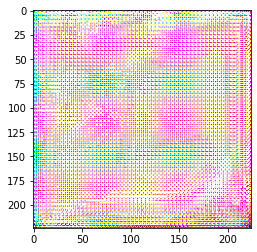

In [9]:
hr_pred = model(lr)
plt.imshow(hr_pred[0]*255)

In [10]:
model.summary()

Model: "my_sr_res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  15616     
_________________________________________________________________
p_re_lu (PReLU)              multiple                  200704    
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
p_re_lu_1 (PReLU)            multiple                  200704    
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_1 (Batch multiple                

## Optimizer, loss and metrics

In [11]:
def ssim(x, y, max_val=1.0):
    return tf.image.ssim(x, y, max_val)

def psnr(x, y, max_val=1.0):
    return tf.image.psnr(x, y, max_val)

optimizer = optimizers.Adam(learning_rate=0.0006,beta_1=0.9)
loss = ['mse']
metrics = [ssim, psnr]

In [12]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

## Training

In [13]:
num_epochs = 5
train_count = 3669
validation_count = 3680
history = model.fit(ds_train, steps_per_epoch=int(train_count/batch_size), validation_data=ds_test, validation_steps=int(validation_count/batch_size), epochs=num_epochs)

Epoch 1/5
114/114 [==============================] - 168s 1s/step - loss: 0.0484 - ssim: 0.1915 - psnr: 15.8159 - val_loss: 0.0337 - val_ssim: 0.2852 - val_psnr: 14.9249
Epoch 2/5
114/114 [==============================] - 162s 1s/step - loss: 0.0097 - ssim: 0.4146 - psnr: 20.6437 - val_loss: 0.0413 - val_ssim: 0.3285 - val_psnr: 14.2328
Epoch 3/5
114/114 [==============================] - 162s 1s/step - loss: 0.0087 - ssim: 0.4704 - psnr: 21.1917 - val_loss: 0.0255 - val_ssim: 0.3930 - val_psnr: 16.2697
Epoch 4/5
114/114 [==============================] - 162s 1s/step - loss: 0.0075 - ssim: 0.5109 - psnr: 21.8336 - val_loss: 0.0089 - val_ssim: 0.4837 - val_psnr: 20.8845
Epoch 5/5
114/114 [==============================] - 162s 1s/step - loss: 0.0069 - ssim: 0.5386 - psnr: 22.2579 - val_loss: 0.0092 - val_ssim: 0.5370 - val_psnr: 20.9433


## Illustrate the training result after a few epochs

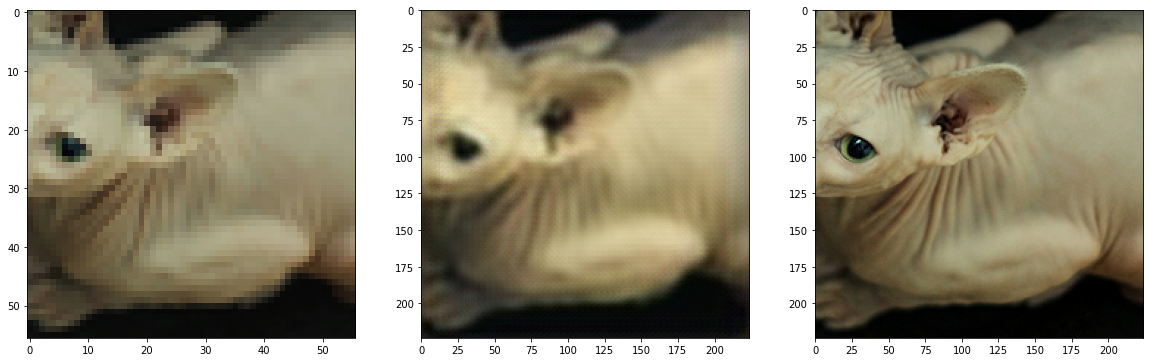

In [14]:
hr_pred = model.predict(lr)

fig,ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(lr[0])
ax[1].imshow(hr_pred[0])
ax[2].imshow(hr[0])


plt.show()

# Results

[Link to TensorBoard Results](http://34.83.132.165:6006/#scalars
)

In [15]:
!ls

index-en.html	  index-en.html.13  index-en.html.4  index-en.html.9
index-en.html.1   index-en.html.14  index-en.html.5  sample_data
index-en.html.10  index-en.html.15  index-en.html.6
index-en.html.11  index-en.html.2   index-en.html.7
index-en.html.12  index-en.html.3   index-en.html.8
